In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## Complete example with the best settings found so far

In [64]:
import os
import shutil
import time
import datetime
import random

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from tensorflow.keras import layers,models,utils,optimizers,regularizers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,LearningRateScheduler
from util.custom_callbacks import SkipLoggerCallback,StepDecayHistoryCallback,LearningRateHistoryCallback
from util.custom_callbacks import step_decay,step_decay_25_864065
from util.clr_callback import CyclicLR 

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']
BATCH_SIZE = 32

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

SOURCE_DATA_DIR = 'data/caps_and_shoes_squared_2/'
TEST_DATA_DIR = 'data/out_of_set_tests/'

In [51]:
def create_test_set(seed=random.randint(1,10000)):

    dirpath = os.path.join(TEST_DATA_DIR, 'temp_test')
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
        shutil.rmtree(dirpath)
        
    os.makedirs(dirpath, exist_ok=True)
    
    for class_name in CLASS_LIST:
        src_dir = os.path.join(SOURCE_DATA_DIR, class_name)
        dest_dir = os.path.join(dirpath, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        
        src_files = (os.listdir(src_dir))
        random.seed(seed)
        choices = random.sample(src_files, 25)
        for file_name in choices:
            shutil.copy(os.path.join(src_dir, file_name), dest_dir)
            
def get_oos_test_accuracy(model=None):
    
    out_test_accuracy_log = []
    
    for iter_count in range(50):
    
        seed = random.randint(1,10000)
        create_test_set(seed)

        test_img_generator = ImageDataGenerator(rescale = 1./255)
        test_batches = test_img_generator.flow_from_directory(os.path.join(TEST_DATA_DIR, 'temp_test'),
                                                              target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                              class_mode = 'categorical', batch_size=32)
        test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
        out_test_accuracy_log.append(test_accuracy)
    
    return (np.mean(out_test_accuracy_log),np.std(out_test_accuracy_log))

def plot_images(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        
        plt.imshow(ims[i].reshape(IMAGE_SIZE[0],IMAGE_SIZE[1]), cmap="gray")

In [5]:
test_img_generator = ImageDataGenerator( rescale = 1./255)
train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')

train_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='training')

validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='validation')

test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical',batch_size=1, shuffle=False)

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


In [6]:
def define_model_architecture_64_32_16():
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

### Step Decay Schedule

In [7]:
EPOCHS = 700

skipLogger_callback = SkipLoggerCallback(n=25)

lrate_callback = LearningRateScheduler(step_decay_25_864065)
callback_list = [lrate_callback, skipLogger_callback]

In [8]:
sgd_optimizer = optimizers.SGD(lr=0.0,momentum=0.9,nesterov=True)
model = define_model_architecture_64_32_16()
model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
start = time.time()
history_step_decay = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)

print('time taken : %.4f' % (time.time() - start))
oos_test_loss, oos_test_accuracy = get_oos_test_accuracy(model)
print('OOS Test loss: %.4f OOS std dev: %.4f' % (oos_test_loss, oos_test_accuracy))    
test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    

W0921 09:11:38.450517 139712583214912 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.690934    accuracy = 0.53    val_loss = 0.664103    val_accuracy = 0.64
epoch =   25    loss = 0.534316    accuracy = 0.73    val_loss = 0.593221    val_accuracy = 0.73
epoch =   50    loss = 0.474215    accuracy = 0.78    val_loss = 0.526580    val_accuracy = 0.77
epoch =   75    loss = 0.442979    accuracy = 0.79    val_loss = 0.535469    val_accuracy = 0.76
epoch =  100    loss = 0.436432    accuracy = 0.80    val_loss = 0.443328    val_accuracy = 0.82
epoch =  125    loss = 0.416823    accuracy = 0.81    val_loss = 0.448294    val_accuracy = 0.80
epoch =  150    loss = 0.404782    accuracy = 0.82    val_loss = 0.543141    val_accuracy = 0.78
epoch =  175    loss = 0.377029    accuracy = 0.84    val_loss = 0.411798    val_accuracy = 0.81
epoch =  200    loss = 0.370463    accuracy = 0.83    val_loss = 0.414292    val_accuracy = 0.82
epoch =  225    loss = 0.368376    accuracy = 0.83    val_loss = 0.411467    val_accuracy = 0.82
epoch =  250    loss = 0.34789

In [10]:
history_dict = {}
history_dict['step_decay'] = history_step_decay
model.save("model/model_step_decay.h5")

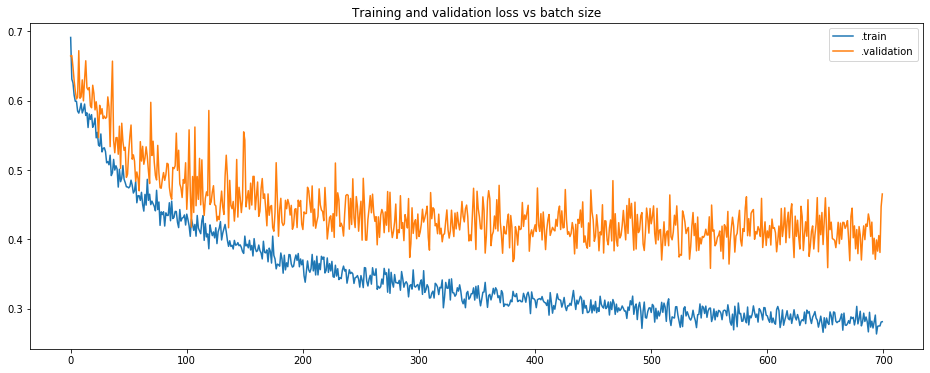

In [11]:
plt.figure(num=None, figsize=(16, 6))

plt.plot(history_step_decay.history['loss'], label= '.train')
plt.plot(history_step_decay.history['val_loss'], label= '.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.show()

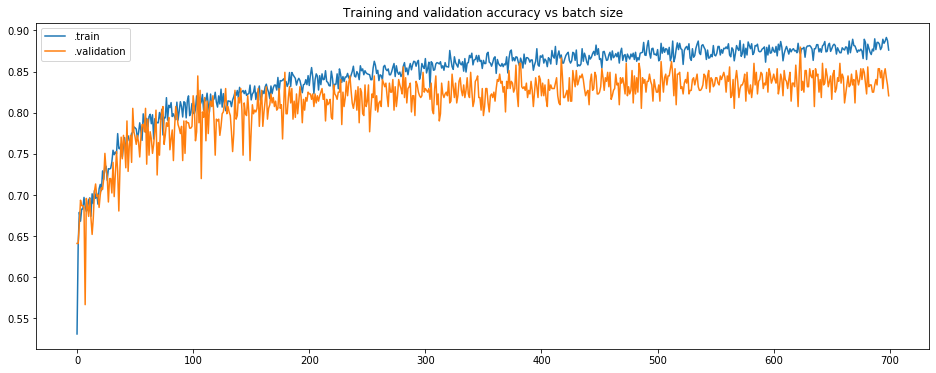

In [12]:
plt.figure(num=None, figsize=(16, 6))

plt.plot(history_step_decay.history['accuracy'], label= '.train')
plt.plot(history_step_decay.history['val_accuracy'], label= '.validation')

plt.legend()
plt.title('Training and validation accuracy vs batch size')
plt.show()

### Triangular Schedule

In [13]:
MIN_LR = 1e-4
MAX_LR = 2e-3
STEP_SIZE = 8
CLR_METHOD = "triangular"
EPOCHS = 79*6

In [14]:
sgd_optimizer = optimizers.SGD(lr=MIN_LR, momentum=0.9, nesterov=True)
model = define_model_architecture_64_32_16()
model.compile(loss="binary_crossentropy", optimizer=sgd_optimizer, metrics=["accuracy"])

In [15]:
skipLogger_callback = SkipLoggerCallback(n=79)
clr_callback = CyclicLR(mode=CLR_METHOD, base_lr=MIN_LR, max_lr=MAX_LR,step_size= STEP_SIZE * (train_batches.samples/BATCH_SIZE))
callback_list = [skipLogger_callback,clr_callback]

In [16]:
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)

print('time taken : %.4f' % (time.time() - start))
oos_test_loss, oos_test_accuracy = get_oos_test_accuracy(model)
print('OOS Test loss: %.4f OOS std dev: %.4f' % (oos_test_loss, oos_test_accuracy))    
test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    

epoch =    0    loss = 0.702629    accuracy = 0.49    val_loss = 0.719916    val_accuracy = 0.56
epoch =   79    loss = 0.443980    accuracy = 0.81    val_loss = 0.452628    val_accuracy = 0.82
epoch =  158    loss = 0.388150    accuracy = 0.83    val_loss = 0.424599    val_accuracy = 0.81
epoch =  237    loss = 0.363733    accuracy = 0.84    val_loss = 0.419799    val_accuracy = 0.82
epoch =  316    loss = 0.325933    accuracy = 0.86    val_loss = 0.386918    val_accuracy = 0.84
epoch =  395    loss = 0.307198    accuracy = 0.87    val_loss = 0.379600    val_accuracy = 0.85
time taken : 2766.6366
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 clas

In [17]:
history_dict = {}
history_dict['traingular'] = history

### Decaying Triangle schdule

In [18]:
MIN_LR = 1e-4
MAX_LR = 2e-3
STEP_SIZE = 8
CLR_METHOD = "triangular2"
EPOCHS = 79

In [19]:
sgd_optimizer = optimizers.SGD(lr=MIN_LR, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=sgd_optimizer, metrics=["accuracy"])

In [20]:
skipLogger_callback = SkipLoggerCallback(n=79)
clr_callback = CyclicLR(mode=CLR_METHOD, base_lr=MIN_LR, max_lr=MAX_LR,step_size= STEP_SIZE * (train_batches.samples/BATCH_SIZE))
callback_list = [skipLogger_callback,clr_callback]

In [21]:
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)

print('time taken : %.4f' % (time.time() - start))
oos_test_loss, oos_test_accuracy = get_oos_test_accuracy(model)
print('OOS Test loss: %.4f OOS std dev: %.4f' % (oos_test_loss, oos_test_accuracy))    
test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

epoch =    0    loss = 0.284986    accuracy = 0.88    val_loss = 0.437874    val_accuracy = 0.82
time taken : 446.4257
Found 48 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
F

In [22]:
history_dict['triangular2'] = history

### Phase 4 Slow learning with decay

In [23]:
MAX_EPOCHS = 2000
iteration = int(train_batches.samples/BATCH_SIZE)*MAX_EPOCHS
learning_rate_start = 0.00050
learning_rate_end = 1e-5
decay = ((learning_rate_start/learning_rate_end) - 1)/iteration
print('computed decay : %.2e' % decay)

computed decay : 4.30e-04


In [24]:
sgd_optimizer = optimizers.SGD(lr=0.00050, decay=4.30e-04,momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=sgd_optimizer, metrics=["accuracy"])

In [25]:
EPOCHS = 200
skipLogger_callback = SkipLoggerCallback(n=25)

In [26]:
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)

print('time taken : %.4f' % (time.time() - start))
oos_test_loss, oos_test_accuracy = get_oos_test_accuracy(model)
print('OOS Test loss: %.4f OOS std dev: %.4f' % (oos_test_loss, oos_test_accuracy))    
test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

epoch =    0    loss = 0.284275    accuracy = 0.87    val_loss = 0.354560    val_accuracy = 0.83
epoch =   79    loss = 0.262883    accuracy = 0.89    val_loss = 0.372738    val_accuracy = 0.83
epoch =  158    loss = 0.274365    accuracy = 0.88    val_loss = 0.359651    val_accuracy = 0.86
time taken : 1142.3765
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 

In [27]:
history_dict['simple_decay'] = history
model.save("model/model_mix_lr.h5")

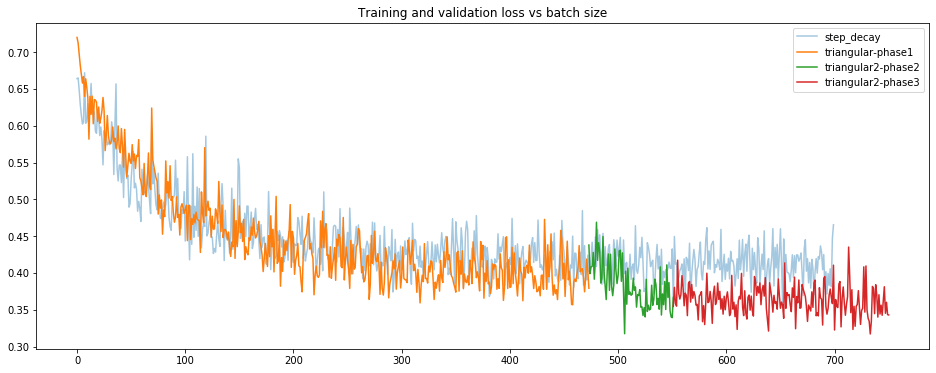

In [45]:
plt.figure(num=None, figsize=(16, 6))

#plt.plot(history_step_decay.history['loss'], label= '.train')
plt.plot(history_step_decay.history['val_loss'], label= 'step_decay', alpha = 0.4)
label_x = [i for i in range(0,len(history_dict['traingular'].history['val_loss']))]
plt.plot(label_x, history_dict['traingular'].history['val_loss'], label= 'triangular-phase1')
label_x2 = [i for i in range(label_x[-1],label_x[-1] + len(history_dict['triangular2'].history['val_loss']))]
plt.plot(label_x2, history_dict['triangular2'].history['val_loss'], label= 'triangular2-phase2')
label_x3 = [i for i in range(label_x2[-1],label_x2[-1] + len(history_dict['simple_decay'].history['val_loss']))]
plt.plot(label_x3, history_dict['simple_decay'].history['val_loss'], label= 'triangular2-phase3')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.show()

In [52]:
test_batches.reset()
actual_labels = []
X_test = []
i = 0
max_iter = test_batches.samples
for data, label in test_batches:
    actual_labels.append(label)
    X_test.append(data)
    i += 1
    if i == max_iter:
        break
        
actual_labels = np.concatenate(actual_labels)
X_test = np.concatenate(X_test)

In [53]:
test_batches.reset()
predictions = model.predict_generator(test_batches)

In [56]:
test_prediction_data = pd.DataFrame(np.hstack([predictions,actual_labels]).astype("float16"), columns=['predicted_cap','predicted_shoes','actual cap','actual_shoes'])
test_prediction_data[:5]

,predicted_cap,predicted_shoes,actual cap,actual_shoes
0,0.982422,0.017502,1.0,0.0
1,0.998535,0.001405,1.0,0.0
2,0.312012,0.687988,1.0,0.0
3,0.971680,0.028351,1.0,0.0
4,0.280762,0.719238,1.0,0.0


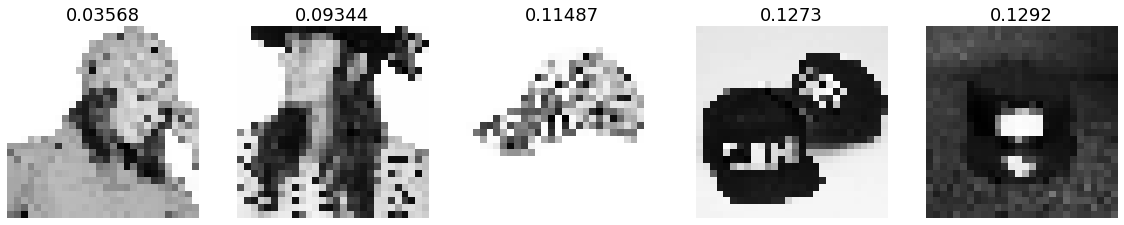

In [57]:
top_wrong_caps_ix = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values().index.values[:5]
top_wrong_caps_values = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values().values[:5]
plot_images(X_test[top_wrong_caps_ix],titles=top_wrong_caps_values)

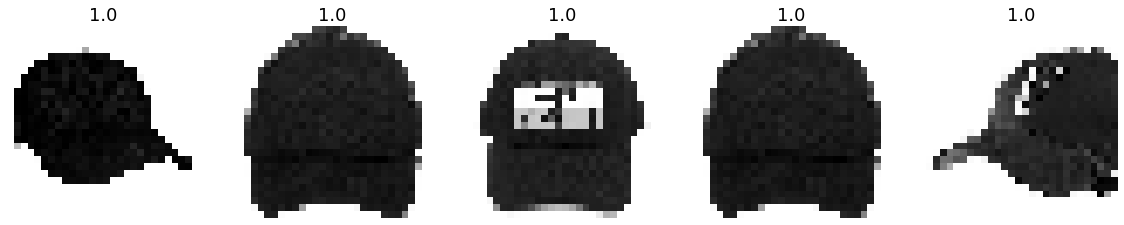

In [58]:
top_correct_caps_ix = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values(ascending=False).index.values[:5]
top_correct_caps_values = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values(ascending=False).values[:5]
plot_images(X_test[top_correct_caps_ix],titles=top_correct_caps_values)

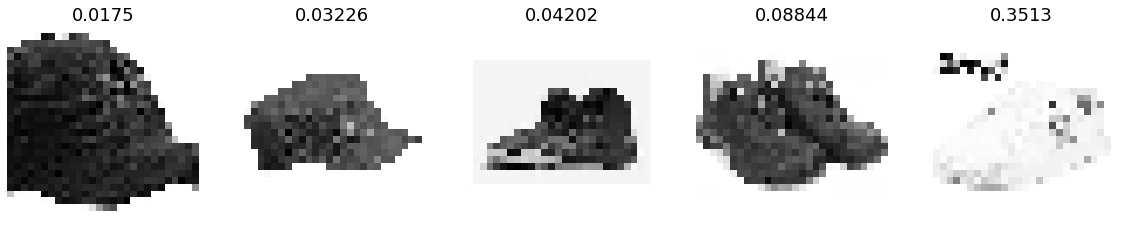

In [59]:
top_wrong_shoes_ix = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values().index.values[:5]
top_wrong_shoes_values = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values().values[:5]
plot_images(X_test[top_wrong_shoes_ix],titles=top_wrong_shoes_values)

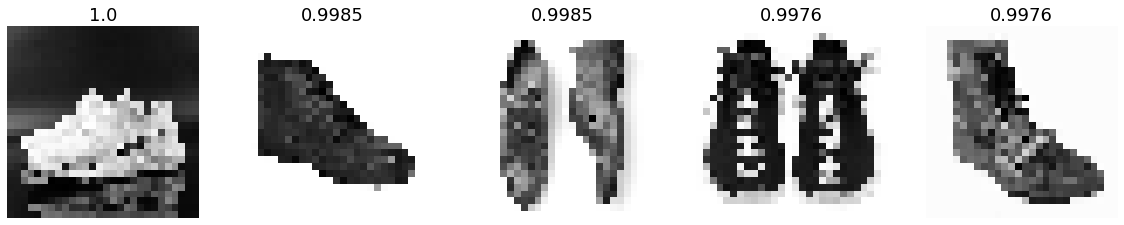

In [60]:
top_correct_shoes_ix = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values(ascending=False).index.values[:5]
top_correct_shoes_values = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values(ascending=False).values[:5]
plot_images(X_test[top_correct_shoes_ix],titles=top_correct_shoes_values)

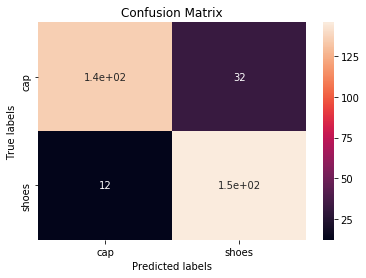

In [65]:
labels = ['cap','shoes']
cm = confusion_matrix(np.argmax(actual_labels ,axis=1), np.argmax(predictions, axis=1), [0,1])

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

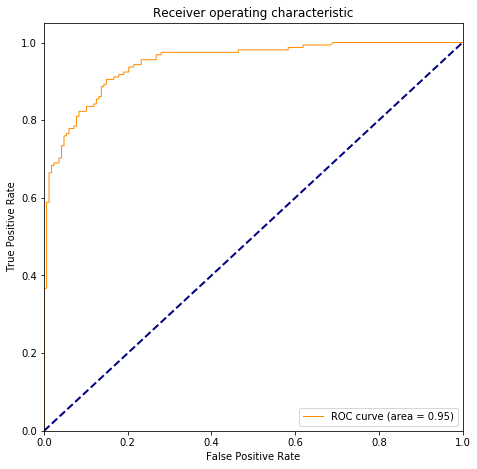

In [66]:
fpr, tpr, thresholds = roc_curve(actual_labels[:,1], predictions[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7.5, 7.5))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()